# IMPORTS

In [1]:
# \\  -------- IMPORTS -------- //

from ast import Return
from codecs import getdecoder
from pkgutil import get_data
from typing import List
from unicodedata import name
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt



import backtrader as bt
import talib

# cyclical imports
from statsmodels.tsa.filters.hp_filter import hpfilter


# for outliers in data cleaning
from scipy import stats

# Data API
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

df = 0
df1 = 0

end = dt.datetime.now()  # end date is now
start = dt.datetime(1980, 1, 1)   # start date 


# IMPORTING DATA

In [2]:
# import asset data
data = yfin.download(("SPY", 'DX-Y.NYB', 'CL=F', 'GBPUSD=X'), start="2004-01-01", end= dt.datetime.now())

data_1 = pd.DataFrame(data["Close"])

# clean the data

df_asset = data_1.asfreq('D')

df_asset = df_asset.interpolate(method = 'linear') # fill gaps to the correct frequency

df_asset = df_asset.fillna(method = 'ffill')

df_asset = df_asset.fillna(method = 'backfill')

df_asset = df_asset[(np.abs(stats.zscore(df_asset)) < 10).all(axis=1)] # remove any extreme outliers

[*********************100%***********************]  4 of 4 completed


In [3]:
# select Asset
asset = 'GBPUSD=X'

In [144]:
df_asset['GBPUSD=X'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 7034 entries, 2004-01-01 to 2023-04-04
Freq: D
Series name: GBPUSD=X
Non-Null Count  Dtype  
--------------  -----  
7034 non-null   float64
dtypes: float64(1)
memory usage: 109.9 KB


# Calculating Indicators

In [4]:
# creating ROC indicators
# correlation of Weekly ROC
weekly_roc = df_asset[asset].diff(periods=7)

# correlation of Monthly ROC
monthly_roc = df_asset[asset].diff(periods=30)

# correlation of Quarterly ROC
quarterly_roc = df_asset[asset].diff(periods=90)

# correlation of 6M ROC
half_year_roc = df_asset[asset].diff(periods=180)

# correlation of Yearly ROC
yearly_roc = df_asset[asset].diff(periods=365)

Rate_of_Change_data = pd.concat([weekly_roc, monthly_roc, quarterly_roc, half_year_roc, yearly_roc], axis=1)

new_columns = ['Weekly_roc', 'Monthly_roc', 'Quarterly_roc', 'Half_year_roc', 'Yearly_roc']
Rate_of_Change_data.columns = new_columns


In [5]:
# creating volatility indicators
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#create empty DataFrame
volatility_data = pd.DataFrame()

weekly_returns = df_asset[asset].pct_change().dropna()

Window = 7 
volatility_data['V_Weekly'] = weekly_returns.rolling(Window).std()
Window_2 = 30
volatility_data['V_Monthly'] = weekly_returns.rolling(Window_2).std()
Window_3 = 90
volatility_data['V_Quarterly'] = weekly_returns.rolling(Window_3).std()
Window_4 = 180
volatility_data['V_Half_Year'] = weekly_returns.rolling(Window_4).std()
Window_5 = 365
volatility_data['V_Year'] = weekly_returns.rolling(Window_5).std()



In [6]:
# ALL INDICATORS IN 1 DATAFRAME

# what relationship - correlation / stationary ?
indicators_df = pd.concat([volatility_data, Rate_of_Change_data], axis=1)

# METHODS OF CHOOSING APPROPRIATE INDICATOR / INDICATORS FOR ASSET

## PCA

In [152]:
# pca

volatility_data = volatility_data.fillna(method = 'ffill')

volatility_data = volatility_data.fillna(method = 'backfill')

# Standardize the data
scaler = StandardScaler()
volatility_data_std = scaler.fit_transform(volatility_data)

# Perform PCA
pca = PCA()
pca.fit(volatility_data_std)

# Extract the principal components and their loadings
pcs = pca.transform(volatility_data_std)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=volatility_data.columns)

# Print the results
print('Explained variance ratio:', pca.explained_variance_ratio_)
print('Principal components:\n', pcs)
print('Loadings:\n', loadings)

Explained variance ratio: [0.7446321  0.1527321  0.06319318 0.02852106 0.01092157]
Principal components:
 [[ 2.08163854 -0.51737097  0.98783033  0.05714935  0.03451836]
 [ 2.08163854 -0.51737097  0.98783033  0.05714935  0.03451836]
 [ 2.08163854 -0.51737097  0.98783033  0.05714935  0.03451836]
 ...
 [ 1.52258088 -1.36935921 -0.41566782  0.22239119  0.49892903]
 [ 1.54830926 -1.28709046 -0.46032489  0.23670347  0.48755061]
 [ 2.48863476 -0.04218722 -1.09897126  0.1473063   0.46589012]]
Loadings:
                   PC1       PC2       PC3       PC4       PC5
V_Weekly     0.369202  0.711480 -0.563125 -0.200225 -0.016922
V_Monthly    0.457306  0.334230  0.487359  0.647609  0.149148
V_Quarterly  0.488378 -0.073263  0.418334 -0.486760 -0.586669
V_Half_Year  0.483909 -0.326955  0.005107 -0.345933  0.734328
V_Year       0.426474 -0.519442 -0.519944  0.428844 -0.306678


In [80]:
pca.explained_variance_ratio_

array([0.86614819, 0.08634286, 0.0306778 , 0.01252722, 0.00430393])

<AxesSubplot:xlabel='Date'>

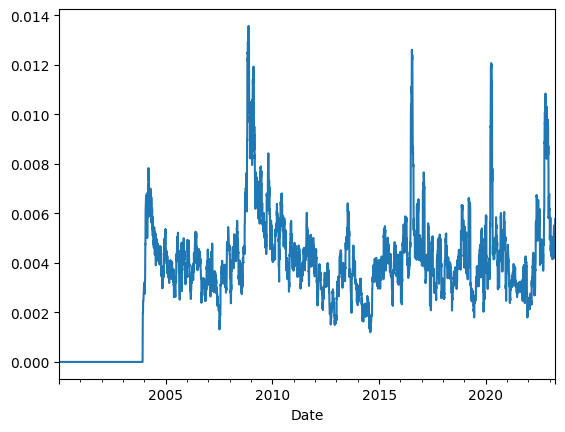

In [82]:
volatility_data['V_Monthly'].plot()

## CORRELATION COEFF

In [7]:
# concat indicators with asset

asset_ind = pd.concat([indicators_df, df_asset[asset]], axis = 1)

# calculate the correlation
asset_ind_corr = asset_ind.corr()

# extract the column with the asset
corr_coeff = asset_ind_corr[asset]

#sort the values and remove the top row
corr_coeff = pd.DataFrame(corr_coeff)
corr_coeff = corr_coeff.sort_values(by = asset, ascending = False)
corr_coeff = corr_coeff.iloc[1:]
corr_coeff

,GBPUSD=X
Yearly_roc,0.350176
Half_year_roc,0.259958
Quarterly_roc,0.164170
Monthly_roc,0.095084
Weekly_roc,0.046368
V_Weekly,-0.117300
V_Monthly,-0.194200
V_Year,-0.237745
V_Quarterly,-0.253428
V_Half_Year,-0.277241


# CREATE THE RULE

<AxesSubplot:xlabel='Date'>

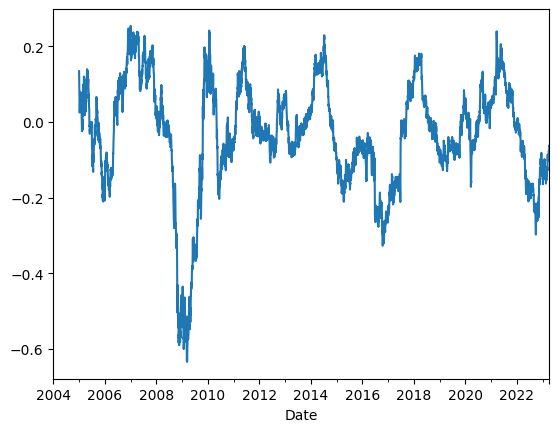

In [8]:
# THE INDICATOR
indicators_df['Yearly_roc'].plot()

Sell
-0.06330645084381104


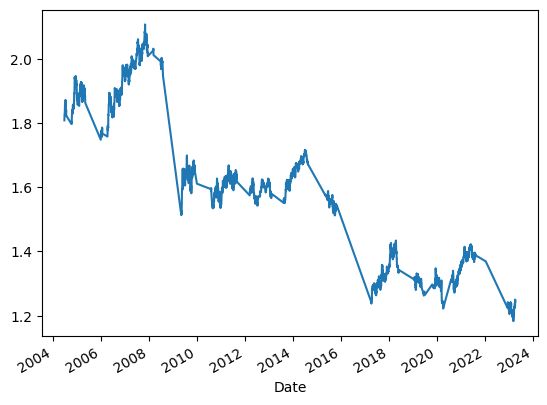

In [78]:
# THE INDICATOR RULE
# Define the rule
buy_data = df_asset[asset][(indicators_df['Half_year_roc'] > 0)]
sell_data = df_asset[asset][(indicators_df['Half_year_roc'] < 0)]


# THE INDICATOR RULE
buy_data.plot() #= df_asset[asset][(indicators_df['Yearly_roc'] < -0.2)]

condition = ''

if indicators_df['Yearly_roc'].tail(1).item() > 0:
    condition = 'Buy'
    print(condition)
else:
    condition = 'Sell'
    print(condition)

print(indicators_df['Yearly_roc'].tail(1).item())

In [33]:
# THE INDICATOR RULE
#buy_data = df_asset[asset][(indicators_df['Yearly_roc'] > -0)]

#
# CREATING THE RETURNS
buy_perf = ((buy_data - buy_data.shift(1)) / buy_data.shift(1))
sell_perf = ((sell_data - sell_data.shift(1)) / sell_data.shift(1))

# convert date column to datetime format
buy_perf['date'] = pd.to_datetime(buy_perf.index)
sell_perf['date'] = pd.to_datetime(sell_perf.index)

buy_perf = pd.DataFrame(buy_perf)
sell_perf = pd.DataFrame(sell_perf)

buy_perf['date'] = buy_perf.index
sell_perf['date'] = sell_perf.index

buy_perf = buy_perf.drop(buy_perf.index[-1])
sell_perf = sell_perf.drop(sell_perf.index[-1])

buy_perf['date'] = pd.to_datetime(buy_perf['date'])
sell_perf['date'] = pd.to_datetime(sell_perf['date'])

buy_perf['diff'] = (buy_perf['date'] - buy_perf['date'].shift(1)).dt.days != 1
sell_perf['diff'] = (sell_perf['date'] - sell_perf['date'].shift(1)).dt.days != 1

# filter out the rows where the diff column is True
buy_perf = buy_perf.loc[~buy_perf['diff'], ['date', asset]]
sell_perf = sell_perf.loc[~sell_perf['diff'], ['date', asset]]

#drop date column 
buy_perf = buy_perf.drop('date', axis = 1)
sell_perf = sell_perf.drop('date', axis = 1)

# replace with incrementing numbers so its all consecutive
buy_perf = buy_perf.reset_index(drop=True)
sell_perf = sell_perf.reset_index(drop=True)

# calculate avg return
buy_perf_avg = buy_perf.mean() * 100
sell_perf_avg = sell_perf.mean() * 100

#convert to float
buy_perf_avg = float(buy_perf_avg)
sell_perf_avg = float(sell_perf_avg)

print(buy_perf_avg)
print(sell_perf_avg)

0.015371387668405675
-0.02107391135302859


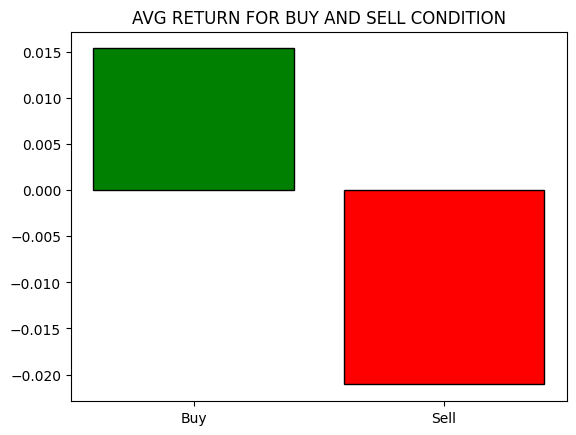

CURRENT CONDITION:  Sell


In [77]:
# ASSETS PERFORMANCE IN EACH QUAD BAR CHART
# create sample data
categories = ['Buy', 'Sell']
values = [buy_perf_avg, sell_perf_avg]

# create the plot
plt.bar(categories, values, color=['green', 'red'], edgecolor='black')

# add x-axis ticks and labels
plt.xticks(categories)

# add a title
plt.title('AVG RETURN FOR BUY AND SELL CONDITION')

# display the plot
plt.show()
print('CURRENT CONDITION: ', condition)

<AxesSubplot:>

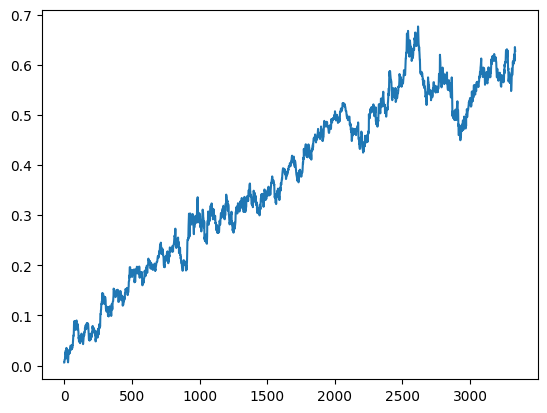

In [37]:
# EQUITY CURVE
#buy_perf.plot()

#cumulative returns
buy_perf['cumulative_returns'] = (1 + buy_perf[asset]).cumprod() - 1
sell_perf['cumulative_returns'] = (1 + sell_perf[asset]).cumprod() - 1
buy_perf['cumulative_returns'].plot()

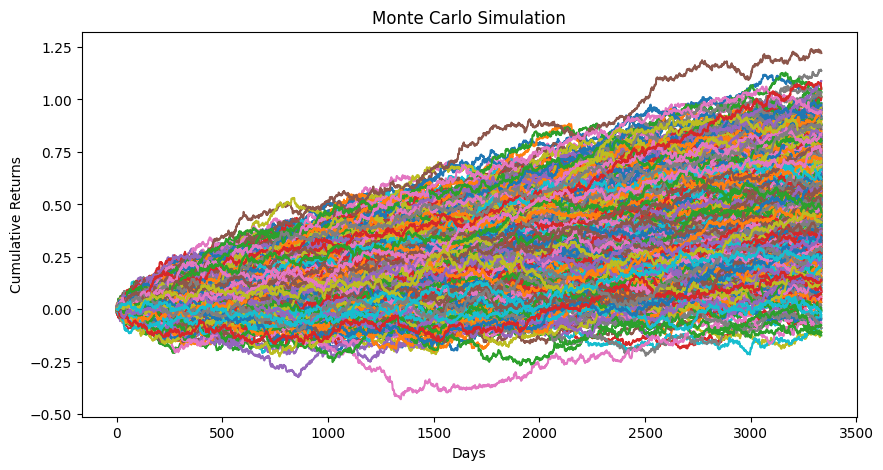

Average End Performance: 0.6555799604569919
Lowest Ending Performance: -0.24434297607124855
Best Ending Performance: 2.45574896179104
Average Return Rate: 0.507868626274745
Average Cumulative Return at 30 days: -0.010802186936002803
Average Cumulative Return at 90 days: 0.0028589920421894233


In [52]:
#monte carlo performance of asset curve in environment

returns = buy_perf[asset]

# define parameters
num_simulations = 1000
trades_per_simulation = len(returns)
end_performance = np.zeros(num_simulations)
win_rates = np.zeros(num_simulations)

# run monte carlo simulation
for i in range(num_simulations):
    sample_returns = returns.sample(n=trades_per_simulation, replace=True)
    cumulative_returns = np.cumprod(1 + sample_returns) - 1
    end_performance[i] = cumulative_returns.iloc[-1]
    win_rates[i] = np.sum(sample_returns > 0) / trades_per_simulation
    
    # calculate cumulative returns for 30 days
    returns_30_days = sample_returns.iloc[:30]
    cumulative_returns_30_days = np.cumprod(1 + returns_30_days) - 1
    avg_cumulative_return_30_days = np.mean(cumulative_returns_30_days)
    
    # calculate cumulative returns for 90 days
    returns_90_days = sample_returns.iloc[:90]
    cumulative_returns_90_days = np.cumprod(1 + returns_90_days) - 1
    avg_cumulative_return_90_days = np.mean(cumulative_returns_90_days)

# plot results
fig, ax = plt.subplots(figsize=(10,5))
for i in range(num_simulations):
    ax.plot(range(1, trades_per_simulation+1), np.cumsum(returns.sample(n=trades_per_simulation, replace=True)))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Monte Carlo Simulation')
plt.show()

#stats
print('Average End Performance:', np.mean(end_performance))
print('Lowest Ending Performance:', np.min(end_performance))
print('Best Ending Performance:', np.max(end_performance))
print('Average Return Rate:', np.mean(win_rates))
print('Average Cumulative Return at 30 days:', avg_cumulative_return_30_days)
print('Average Cumulative Return at 90 days:', avg_cumulative_return_90_days)


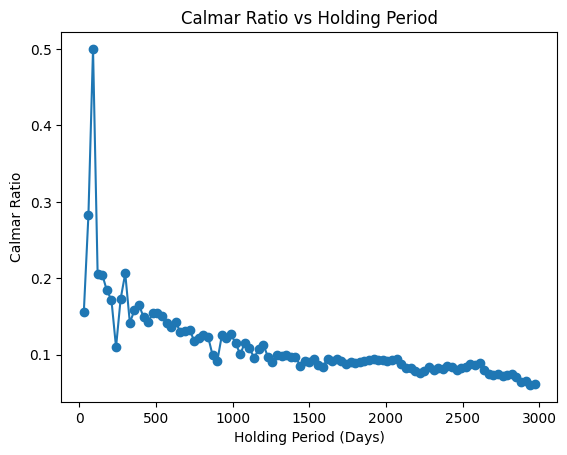

Highest Calmar Ratio: 0.5001076989146721 at holding period of 90
Lowest Calmar Ratio: 0.0604079759345222 at holding period of 2940


In [62]:
# FIND OPTIMAL HOLDING TIME USING CALMAR RATIO
# Define holding periods
holding_periods = list(range(30, 3000, 30))

# Calculate Calmar ratio for each holding period
calmar_ratios = []
for holding_period in holding_periods:
    # Calculate cumulative returns for each holding period
    cumulative_returns = np.cumprod(1 + returns.iloc[:holding_period]) - 1
    
    # Calculate maximum drawdown for each holding period
    rolling_max = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = np.min(drawdown)
    
    # Calculate annualized return for each holding period
    annualized_return = (1 + cumulative_returns.iloc[-1])**(365/holding_period) - 1
    
    # Calculate Calmar ratio for each holding period
    calmar_ratio = annualized_return / np.abs(max_drawdown)
    calmar_ratios.append(calmar_ratio)

# Calculate average Calmar ratio for each holding period
avg_calmar_ratios = np.mean(calmar_ratios, axis=0)

plt.plot(holding_periods, calmar_ratios, marker='o')

# Add x and y axis labels and a title
plt.xlabel('Holding Period (Days)')
plt.ylabel('Calmar Ratio')
plt.title('Calmar Ratio vs Holding Period')

# Show the chart
plt.show()

highest_ratio = max(calmar_ratios)
lowest_ratio = min(calmar_ratios)

index_of_highest_ratio = calmar_ratios.index(highest_ratio)
index_of_lowest_ratio = calmar_ratios.index(lowest_ratio)

print(f"Highest Calmar Ratio: {highest_ratio} at holding period of {holding_periods[index_of_highest_ratio]}")
print(f"Lowest Calmar Ratio: {lowest_ratio} at holding period of {holding_periods[index_of_lowest_ratio]}")


# Testing